In [25]:
suppressPackageStartupMessages(source("/Users/klagattu/Downloads/tcrpheno_analysis_github/utils.R"))
setwd("/Users/klagattu/Downloads/tcrpheno_analysis_github/data")

## Figure 4a

In [69]:
print(load("md10xg_fullmetadata_0411.RData"))
print(load("antigenresiduals_gmmNZ0505_add2_nooffset.RData"))
df = readRDS("10xG_LR0606scores_scaled_wcex_fixDV0629.rds")
print(load("10xG_mappedto_supCCA_combatT_100gpd_10prots_scaled_combat_QC1007_knnCD.RData"))
umap = data.frame(res$umap)
colnames(umap) = c("UMAP1.sup", "UMAP2.sup")
umap$cell = res$meta_data$cell
data = left_join(data, umap)

[1] "data"   "datadd"
[1] "R"         "gmm_plots" "gmm_means" "gmm_vars" 
[1] "res"   "preds"


Joining, by = "cell"


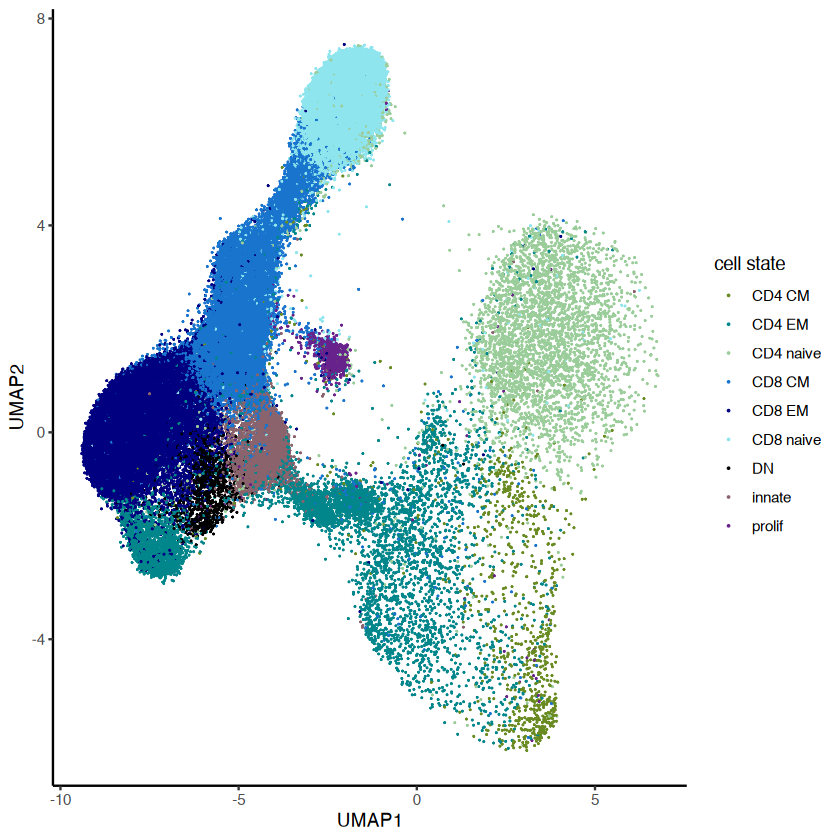

In [46]:
options(repr.plot.width=7, repr.plot.height=7)
tp = data[!(is.na(data$UMAP1.sup)),] ##passing RNA-QC
g = ggplot(tp, aes(UMAP1.sup, UMAP2.sup, color=cmem))
g = g + geom_point_rast(size=0.001) + theme_classic() + scale_color_manual(values=c("olivedrab4", "turquoise4", "darkseagreen3", "dodgerblue3", "navyblue","cadetblue2", "black", "pink4", "darkorchid4"))
g + xlab("UMAP1") + ylab("UMAP2") + labs(color="cell state")

In [70]:
data = left_join(data, df)
set.seed(27)
datadd = data[!(duplicated(data$clone)),]

Joining, by = "cell"


In [72]:
table(is.na(data$cmem), is.na(data$UMAP1.sup))

       
         FALSE   TRUE
  FALSE 185276      0
  TRUE       0   4236

In [48]:
thresh_file = read.csv("antigen_thresh_0522.csv")
thresholds = thresh_file$threshold
names(thresholds) = paste(thresh_file$antigen, thresh_file$donor)

In [73]:
call = call_antigens(R=R, thresholds=thresholds, md10xg=datadd[datadd$pred!="8",])
call.cex = call_antigens(R=R, thresholds=thresholds, md10xg=data[data$pred!="8",])

[1] "number of calls per cell:"

     0      1      2      3      4      5      6      7      8      9     10 
136651  34775  11773   4088   1405    493    197     78     36     14      1 
    11 
     1 
[1] "number of calls per cell:"

     0      1      2      3      4      5      6      7      8      9     10 
136651  34775  11773   4088   1405    493    197     78     36     14      1 
    11 
     1 


In [76]:
##filter to cells passing RNAqc
data = data[!(is.na(data$UMAP1.sup)),]
datadd = datadd[!(is.na(datadd$UMAP1.sup)),]

In [77]:
betas = testTCRscore_perantigen(call, md10xg=datadd[datadd$pred!="8",], stain_cov=TRUE, remove_CD4s = TRUE)

[1] "analyzing 10860 cells"
[1] "analyzing 32 antigens prior to N/M thresh"
[1] "29 antigens retained"
[1] "positive beta?"

FALSE  TRUE 
   10    19 
[1] "(nominally significant):"

TRUE 
   5 


In [90]:
betas = betas[order(-betas$b),]
head(betas[grepl("YLND", betas$antigen),])

,antigen,b,se,p,n,b.stain,se.stain,p.stain,xlab
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
8,A0201_YLNDHLEPWI_BCL.X_Cancer,0.2096783,0.104807,0.04543413,423,-0.1671603,0.1095912,0.1271824,YLNDHLEPWI


In [78]:
rma(betas$b, sei=betas$se, measure="OR", method="ML")


Random-Effects Model (k = 29; tau^2 estimator: ML)

tau^2 (estimated amount of total heterogeneity): 0.0111 (SE = 0.0095)
tau (square root of estimated tau^2 value):      0.1056
I^2 (total heterogeneity / total variability):   29.81%
H^2 (total variability / sampling variability):  1.42

Test for Heterogeneity:
Q(df = 28) = 39.8972, p-val = 0.0675

Model Results:

estimate      se    zval    pval   ci.lb   ci.ub     
  0.1079  0.0372  2.8962  0.0038  0.0349  0.1809  ** 

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [79]:
tp = call.cex[call.cex$antigen %in% betas$antigen,]
tp = left_join(tp, data[,c("cell", "cmem")])
tp = tp[!(is.na(tp$cmem)),]
tp = tp[!(grepl("CD4", tp$cmem)),]
tp = tp[tp$cmem!="DN",]
gr = tp %>% group_by(antigen, cmem) %>% dplyr::summarise(n = length(unique(cell)))
totals = tp %>% group_by(antigen) %>% dplyr::summarise(total = length(unique(cell)))
gr = left_join(gr, totals)
gr$prop = gr$n/gr$total
gr$xlab = sapply(gr$antigen, function(x) strsplit(x, "_")[[1]][2])
betas = betas[order(betas$b),]
betas$xlab = sapply(betas$antigen, function(x) strsplit(x, "_")[[1]][2])
gr$xlab = factor(gr$xlab, levels=betas$xlab)

Joining, by = "cell"
`summarise()` has grouped output by 'antigen'. You can override using the `.groups` argument.
Joining, by = "antigen"


## Figure 4b

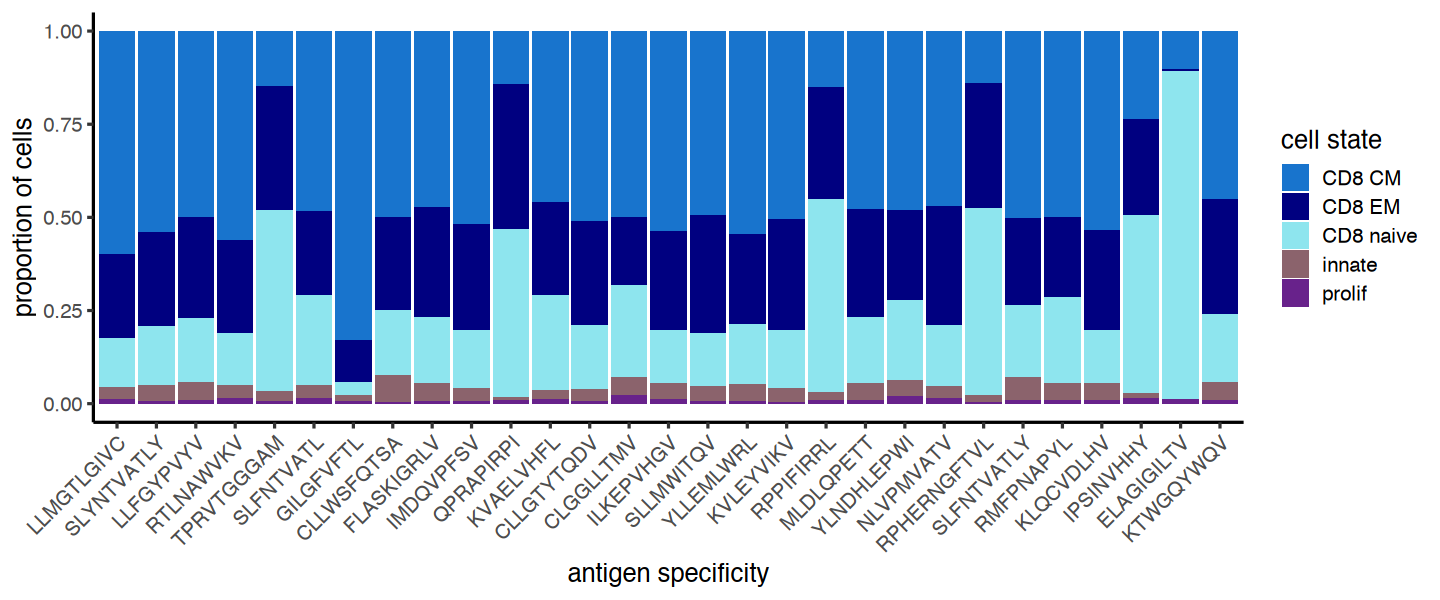

In [80]:
options(repr.plot.width=12, repr.plot.height=5)
g = ggplot(gr, aes(x=xlab, prop, fill=cmem))
g = g + geom_bar(stat="identity", position="stack") + theme_classic(base_size=15)
g = g + scale_fill_manual(values=c("dodgerblue3", "navyblue","cadetblue2","pink4", "darkorchid4")) + labs(fill="A2") + ylab("proportion of cells")
g = g + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1), title=element_text(hjust=0.5))
g + xlab("antigen specificity") + labs(fill="cell state")

In [81]:
grid = readRDS("IMGT_gridTRAVref.rds")
grid$gene = gsub("/DV", "DV", grid$gene)

In [97]:
datadd = left_join(datadd, grid[c("gene", "TRA_p63")], by=c("TCRA_vgene"="gene"))
datadd$TRA_p63_charge = 0
datadd$TRA_p63_charge[datadd$TRA_p63 %in% c("D", "E")] = -1
datadd$TRA_p63_charge[datadd$TRA_p63 %in% c("K")] = 1

In [98]:
ylnd = datadd[datadd$cell %in% call$cell[call$antigen=="A0201_YLNDHLEPWI_BCL.X_Cancer"],]
other = datadd[!(datadd$cell %in% call$cell[call$antigen=="A0201_YLNDHLEPWI_BCL.X_Cancer"]),]

## Figure 4c

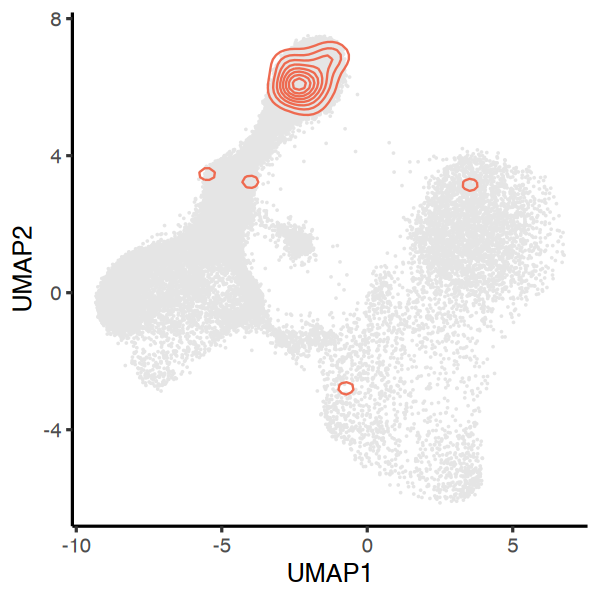

In [107]:
options(repr.plot.width=5, repr.plot.height=5)
fg = ylnd[ylnd$TRA_p63_charge==1,]
g = ggplot()
g = g + theme_classic(base_size=15) + ylab("UMAP2") + xlab("UMAP1")
g = g + geom_point(aes(x=other$UMAP1.sup, y=other$UMAP2.sup), size=0.001, color="gray90")
g + geom_density_2d(aes(x=fg$UMAP1.sup, y=fg$UMAP2.sup), color="coral2")

## Figure 4d

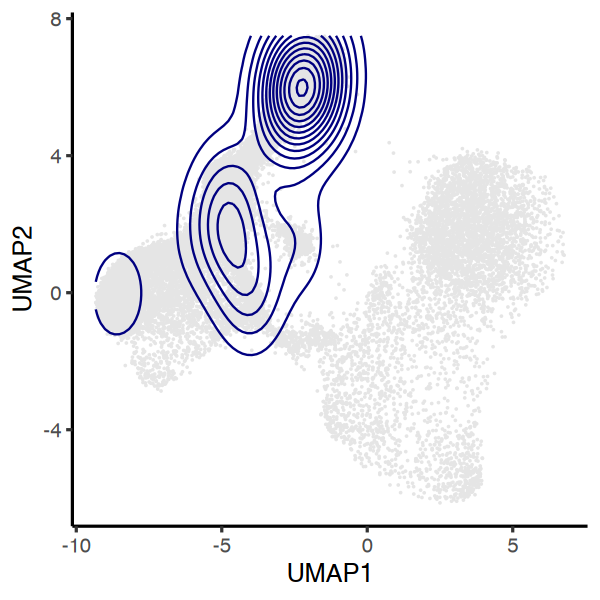

In [106]:
options(repr.plot.width=5, repr.plot.height=5)
fg = ylnd[ylnd$TRA_p63_charge==(-1),]
g = ggplot()
g = g + theme_classic(base_size=15) + ylab("UMAP2") + xlab("UMAP1")
g = g + geom_point(aes(x=other$UMAP1.sup, y=other$UMAP2.sup), size=0.001, color="gray90")
g + geom_density_2d(aes(x=fg$UMAP1.sup, y=fg$UMAP2.sup), color="navyblue")

## Figure 4f

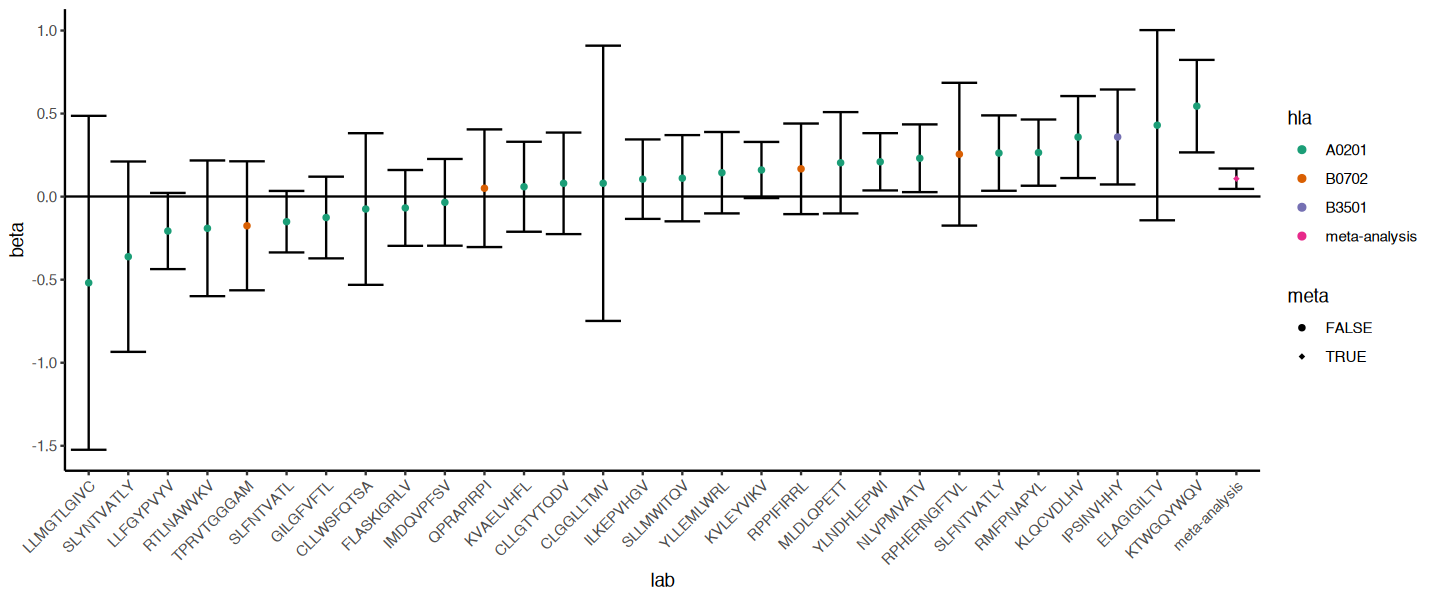

In [56]:
antigen_forest_plot(betas, colorHLA = TRUE, meta_hline = FALSE)